# Demonstrate basic functionality of confit

## Imports

We need to explictly add the path to the library since we haven't installed it yet.

In [1]:
import time

In [2]:
start_time = time.time()
from pathlib import Path
import confitti
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns

Check that we have the right module

In [3]:
confitti?

## Where to save the figures

In [4]:
figpath = Path.cwd().parent / "figs"
saveprefix = "demo01"

## Test data

Symmetric arrangement of 7 points, which I then stretch and distort to make it more interesting.  Using fewer than 7 points is not recommended, although it is possible to ge spectacularly small residuals that way!

In [5]:
xpts, ypts = np.array([1, 2, 3, 4, 5, 6, 7]), np.array([0, 4, 6, 7, 6, 4, 0])
ypts += xpts
xpts *= 3

Plot the points

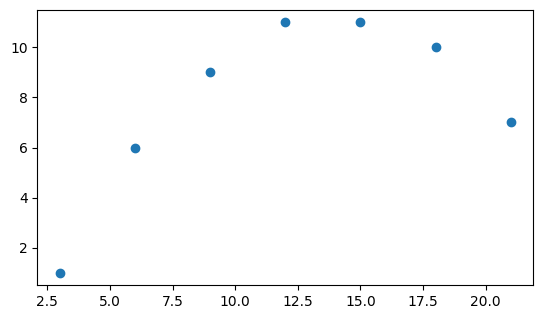

In [6]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts)
ax.set_aspect("equal")
...;

In [7]:
fig.savefig(figpath / f"{saveprefix}-points.pdf", bbox_inches="tight")

## Initial guess at conic parameters

This is done automatically inside the fitting function, but we will do it explicitly so we can see what it is doing

In [8]:
initial_conic = confitti.init_conic_from_xy(xpts, ypts)
initial_conic

{'x0': 12.0,
 'y0': 7.857142857142857,
 'r0': 4.670003423475774,
 'theta0': 96.9268304461369,
 'eccentricity': 1.0}

Look at the residuals for this initial guess, which is
$$
r - e d
$$
where $r$ is the radius of each point from the focus and $d$ is the distance of each point from the directrix.

We turn on DEBUG so that the residual function will print out the individual vectors, $r$, $d$, and $e \times d$.

In [9]:
initial_params = lmfit.create_params(**initial_conic)
confitti.DEBUG = True
confitti.residual(initial_params, xpts, ypts)

array([-3.74707344, -4.17914182, -4.6333713 , -3.07723235, -2.23706426,
       -1.56522843, -2.23558463])

The residuals are all negative, meaning points are inside the conic. This suggests that `r0` is overestimated.

Turn the `DEBUG` flag back off.

In [10]:
confitti.DEBUG = False

## Do the fitting

We first fit a parabola ($e = 1$) by setting `only_parabola=True`, which is not strictly necessary since it is the default. And then another fit of a general conic with `only_parabola=False` so that the eccentricity is allowed to vary.

In [11]:
result_p = confitti.fit_conic_to_xy(xpts, ypts, only_parabola=True)
result_e = confitti.fit_conic_to_xy(xpts, ypts, only_parabola=False)

Compare the two results

In [12]:
result_p

In [13]:
result_e

So the best general conic fit is an ellipse with quite a high eccentricity. The scale `r0` (the distance from the focus to the apex) is quite similar to the initial guess, and so is the orientation `theta`. The position of the focus `x0, y0` has changed a bit though.

There is very little difference between the parameters of the parabola fit and the general conic fit. The chi-square is slightly lower for the general fit. But the number of degrees of freedom is lower bbecause of the ectra parameter, so the reduced chi-square is larger. This means that there is little justification for using the general conic in this case.

On the other hand, the uncertainty on the angle and radius are significantly higher for the general fit, which might be more realistic. These uncertainties are calculated from the Hessian matrix and are not necessarily accurate, since we are not using any real errors in the data points. We will get better estimate of parameter uncertainties from MCMC later.

There are some significant correlations between parameters, whic is also better studied via MCMC.

Look at the residuals:

In [14]:
result_p.residual

array([-0.029657  ,  0.09711228, -0.15980904,  0.20396388, -0.24071303,
        0.20138744, -0.07228452])

In [15]:
result_e.residual

array([ 0.01612997,  0.03542924, -0.17974089,  0.2592089 , -0.22631126,
        0.12003342, -0.02474937])

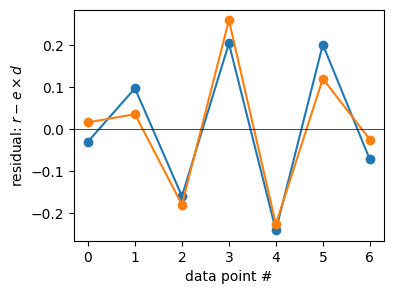

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(result_p.residual, "-o")
ax.plot(result_e.residual, "-o")
ax.axhline(0, color="k", lw=0.5)
ax.set(
    xlabel="data point #",
    ylabel=r"residual: $r - e \times d$",
)
...;

In [17]:
fig.savefig(figpath / f"{saveprefix}-residuals.pdf", bbox_inches="tight")

This shows that the general conic (orange) fits slightly better in the wings (data points 1, 2, 5, 6) but the residuals are much larger around the apex, and no smooth curve could do anything to improve that.

Now look at the distances that go into the residuals.

In [18]:
confitti.DEBUG = True
confitti.residual(result_p.params, xpts, ypts)
confitti.DEBUG = False

In [19]:
confitti.DEBUG = True
confitti.residual(result_e.params, xpts, ypts)
confitti.DEBUG = False

This was more informative for an earlier version of this demo.

## Plotting the best fit onto the data

In [20]:
bestp_xy = confitti.XYconic(**result_p.params.valuesdict())
print(bestp_xy)

Conic section curve with focus at (13.960432263320762, 8.230286421708369), scale factor 2.9827087717320344, angle 90.18600410981117, and eccentricity 1.0.


/Users/will/Dropbox/confitti/src/confitti/confitti.py:143: RuntimeWarning: divide by zero encountered in divide
  self.r0


In [21]:
beste_xy = confitti.XYconic(**result_e.params.valuesdict())
print(beste_xy)

Conic section curve with focus at (14.183693736314082, 7.944283966677202), scale factor 3.2422003252615683, angle 87.8025893458632, and eccentricity 0.9336253665583254.


In [22]:
init_xy = confitti.XYconic(**initial_conic)
print(init_xy)

Conic section curve with focus at (12.0, 7.857142857142857), scale factor 4.670003423475774, angle 96.9268304461369, and eccentricity 1.0.


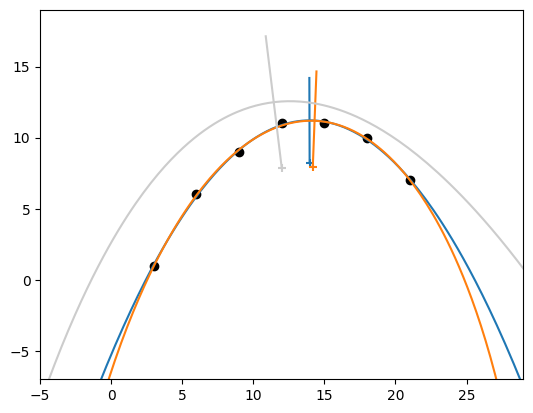

In [23]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts, color="k")

c = "C0"
ax.plot(bestp_xy.x_pts, bestp_xy.y_pts, color=c)
ax.scatter(bestp_xy.x0, bestp_xy.y0, marker="+", color=c)
ax.plot([bestp_xy.x0, bestp_xy.x_mirror], [bestp_xy.y0, bestp_xy.y_mirror], color=c)

c = "C1"
ax.plot(beste_xy.x_pts, beste_xy.y_pts, color=c)
ax.scatter(beste_xy.x0, beste_xy.y0, marker="+", color=c)
ax.plot([beste_xy.x0, beste_xy.x_mirror], [beste_xy.y0, beste_xy.y_mirror], color=c)

c = "0.8"
ax.plot(init_xy.x_pts, init_xy.y_pts, color=c)
ax.scatter(init_xy.x0, init_xy.y0, marker="+", color=c)
ax.plot([init_xy.x0, init_xy.x_mirror], [init_xy.y0, init_xy.y_mirror], color=c)

ax.set_aspect("equal")
margin = 8
ax.set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [24]:
fig.savefig(figpath / f"{saveprefix}-best-fits.pdf", bbox_inches="tight")

## Execution time for notebook

In [25]:
print(f"--- {time.time() - start_time} seconds ---")

--- 13.85698390007019 seconds ---
